In [1]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pybinding.repository import graphene
from IPython.display import display, HTML

In [2]:

a_cc = graphene.a_cc
a = graphene.a

In [3]:
class solver:
    def define_solver(self, model):
        self.a_lat = a_suplat
        self.solver_model = pb.solver.lapack(model)
        self.Gamma = [0, 0]
        self.X = [np.pi/(self.a_lat), 0]
        self.Gamma_prime = [2*np.pi/self.a_lat, 0]
        self.X_prime = [np.pi/(self.a_lat)*1.5, 0]
        self.Gamma_prime2 = [2*(2*np.pi/self.a_lat), 0]
        
    def plots_band(self, ylim = 1, ylimswitch = False, show_H = False, loadDat = False,
                   band_title = '', dos_title = '', showDos = True, dos_broadening = 0.025, 
                   bandEnergySave = False, bandEnergy_name = '',
                   dosSave = False, dos_name = ''):        
        
        self.ylim = ylim
        self.bands_model = self.solver_model.calc_bands(self.Gamma, self.X, self.Gamma_prime,step = 0.01)
        #####################################################
        if bandEnergySave == True:
            pb.save(self.bands_model.energy, bandEnergy_name)
            
        if show_H == True:
            H = model.hamiltonian.todense()
            print('Hamiltonian\n', H)
            print(len(H))
        #####################################################
        
        #plt.figure(1, figsize=(15,10))
        plt.subplot(121)
        
        if loadDat == True:
            data1 = np.loadtxt('DFT-LDA_bandplot_97AGNR.dat')
            X = data1[:,0]
            Y = data1[:,1] - 0.25
            plt.scatter(X,Y,s = 0.2, color='k')#size = 5)   
            
        self.bands_model.plot()

        step = 0.05 * ylim
        if ylimswitch == True:
            plt.yticks(np.arange(-ylim, ylim, step))
            plt.ylim(-ylim, ylim)

        if showDos == True:
            plt.subplot(122)
            plt.title(dos_title)
            plt.yticks(np.arange(-ylim, ylim, step))
            self.dos_broadening = dos_broadening
            dos = self.solver_model.calc_dos(
                    energies = np.linspace(-self.ylim, self.ylim, 400),
                    broadening = self.dos_broadening)  # [eV]
    
            plt.plot(dos.data, np.linspace(-self.ylim, self.ylim, 400))
        #plt.show()
    def plots_spldos1(self, sp_ldos_energy, sp_ldos_broadening, spl_title = ''):
        #plt.figure(figsize = (15, 10))
        plt.title(spl_title)
        sp_ldos_model = self.solver_model.calc_spatial_ldos(energy = sp_ldos_energy,
                                                            broadening= sp_ldos_broadening)
        sp_ldos_model.plot()
        pb.pltutils.colorbar(label="LDOS")

    def plots_dos(self, dos_broadening = 0.05):
        dos = self.solver_model.calc_dos(
              energies = np.linspace(-self.ylim, self.ylim, 200),
              broadening = dos_broadening)  # [eV]
        AA = dos.data
        plt.plot(AA, np.linspace(-self.ylim, self.ylim, 200))

In [4]:
# Calcaulation for Z2 invarinat
def Calc_z2invariant(N, edge = None):      # N is AGNR width
    if edge =='zigzag_closed':
        Z2 = (1+(-1)**(int(N/3)+int((N+1)/2)))/2
    elif edge =='zigzag_open':
        Z2 = (1-(-1)**(int(N/3)+int((N+1)/2)))/2
    elif edge =='bearded':
        Z2 = (1-(-1)**(int(N/3)))/2
    return Z2

In [5]:
class Z2inv:
    edge_list = []       # edge_list is made for showing edge state value
    
    def Gen_Z2_seed(self, N = 1, edge = ''):
        if N%2 == 1:
            if edge == 'Czig':
                self.seed = [5, 7, 9]
            elif edge == 'Ozig':
                self.seed = [1, 3, 11]
        if N%2 == 0:
            if edge == 'Czig':
                self.seed = [2, 4, 6]
            elif edge == 'Bearded':
                self.seed = [4, 10]

    
    def Gen_Z2_(self, N = 1, edge = '', Z2 =1, num_cycle = 3):
        mod = 12            # modula 12 is used for Z2 invariants of the AGNR system 
        Z2_list = []
        edge = edge
        self.Gen_Z2_seed(N = N, edge = edge)
        for i in range(0, num_cycle):
            for j in range(0, len(self.seed)):
                Z2_list.append(self.seed[j]+ 12*i)

        if Z2 == 1:
            res = Z2_list
        elif Z2 == 0:
            domain = np.arange(0+ 1*(N%2), mod*num_cycle, 2)
            res = np.setdiff1d(domain, Z2_list)


        return res
    #print(Gen_Z2(N = 5, edge = 'Czig', Z2 = 1, num_cycle = 2))
    #print(Gen_Z2(N = 5, edge = 'Czig', Z2 = 0, num_cycle = 2))
    
    def Get_Z2(self, N = 1, num_seg = 1, ytrans = 0):      # num_seg = 1 indicates left AGNR segment,
        if N%2 == 1:                                       # num_seg = 2 for right one.
            self.edge = 'Czig'
        elif N%2 == 0:
            if num_seg == 2 and ytrans%2 == 1:
                self.edge = 'Ozig'
            else:
                self.edge = 'Czig'
        
        self.edge_list.append(self.edge)
        self.Gen_Z2_seed(N=N, edge=self.edge)
        #print('self.seed', self.seed)
        #print('self.seed[:-1]', self.seed[-1])

        num_cycle = (N-self.seed[-1])//12 + 2
        #print('Gen_Z2_seed', seed)
        #print('num_cycle', num_cycle)
        Z2 = self.Gen_Z2_(N = N, edge = self.edge, Z2 = 1, num_cycle = num_cycle)
        #print('Z2', Z2)
        if Z2.count(N) == 1:
            Z2inv = 1
        else:#if np.count_nonzero(Z2 == N) == 0:
            Z2inv = 0

        #print('Z2inv', Z2inv)
        return Z2inv

#test_class = Z2inv()
#for i in range(1, 20):
#    print('N', i)
#    print(test_class.Get_Z2(N = i, num_seg = 1))

In [6]:
def Lat_two_seg_AGNR(N_seg1, N_seg2, start_y_seg2=0, 
               t1=graphene.t, t2=graphene.t, t_interface=graphene.t, 
               onsite1=0, onsite2=0, onsite_inter=0):
    num_column1, num_column2 = 3, 3
    num_columns = num_column1 + num_column2
    global a_suplat
    a_suplat = 3*a_cc * num_columns
    lat = pb.Lattice(a1 = [a_suplat, 0],
                     a2 = [0, graphene.a * (N_seg1-1)/2])

    chr_up, chr_low, = [], []
    for j in range(0, num_columns):
        chr_up.append([]), chr_low.append([])
        for i in range(0, N_seg1):
            temp_up  = chr(65+j%26) + chr(65 + i%26)
            temp_low = chr(65+j%26) + chr(65+32 + i%26)
            for k in range(0, (i)//26):
                temp_up  += chr(ord('+'))
                temp_low += chr(ord('+'))
                
            chr_up[j].append( temp_up)
            chr_low[j].append(temp_low)
    
    N_loop_end = N_seg1
    cor = 0
    var_cor = start_y_seg2
    E_onsite_up, E_onsite_low = onsite1, onsite1
    for j in range(0, num_columns):
        ###################################################################
        if j >=num_column1:
            N_loop_end = N_seg2 + start_y_seg2 
            cor = var_cor
            if j == num_column1:
                E_onsite_up = onsite_inter
            elif j == num_columns:
                E_onsite_low = onsite_inter
            else:
                E_onsite_up, E_onsite_low = onsite2, onsite2
        ###################################################################        
        for i in range(0 + cor, N_loop_end):
            #print(i, 'adding a sublattice')
            
            if i%2 == 1:
                lat.add_sublattices(
                    (chr_up[j][i],  [0        +j*(3*a_cc),         0 + a/2*i], E_onsite_up))
                lat.add_sublattices(
                    (chr_low[j][i], [2*a_cc   +j*(3*a_cc),         0 + a/2*i], E_onsite_low))
            elif i%2 == 0:
                lat.add_sublattices(
                    (chr_up[j][i],  [a_cc/2   +j*(3*a_cc), - a*1/2*0 + a/2*i], E_onsite_up))
                lat.add_sublattices(
                    (chr_low[j][i], [a_cc*3/2 +j*(3*a_cc), - a*1/2*0 + a/2*i], E_onsite_low))



            
    N_loop_end = N_seg1
    cor = 0
    t = t1
    for j in range(0, num_columns):
        ###################################################################
        if j >= num_column1:
            t = t2
            N_loop_end = N_seg2 + start_y_seg2
            cor = var_cor
        ###################################################################
        for i in range(0 + cor, N_loop_end):            
            if i != N_loop_end - 1:
                lat.add_hoppings(([0,  0], chr_up[j][i],  chr_up[j][i+1],   t))
                lat.add_hoppings(([0,  0], chr_low[j][i], chr_low[j][i+1],  t))

            if i%2 == 1 and j>=1 and j<= num_columns-1:# and i  <= N_loop_end:
                #print(j,'th column bonding with j+1 th column')
                if j == num_column1:
                    lat.add_hoppings(([0,  0], chr_up[j][i],  chr_low[j-1][i], t_interface))
                else:
                    lat.add_hoppings(([0,  0], chr_up[j][i],  chr_low[j-1][i], t))
            if i%2 == 0:
                lat.add_hoppings(([0,  0], chr_up[j][i],  chr_low[j][i],   t))
            if i%2 == 1 and j == num_columns-1:
                lat.add_hoppings(([1,  0], chr_low[j][i],  chr_up[0][i],   t_interface))

        
            
    return lat

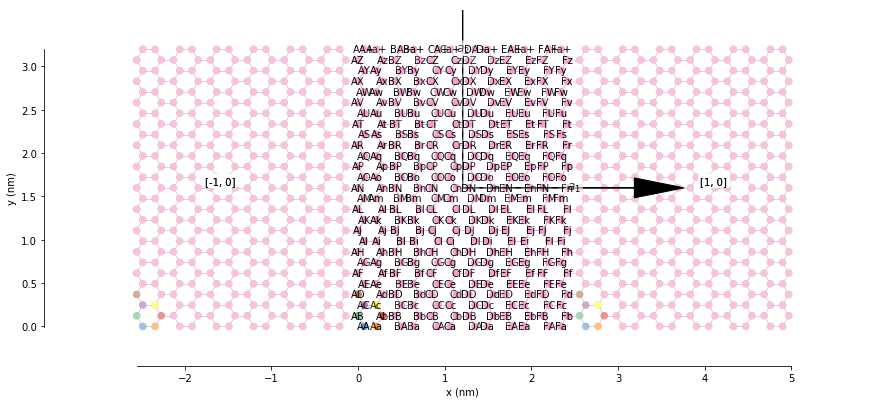

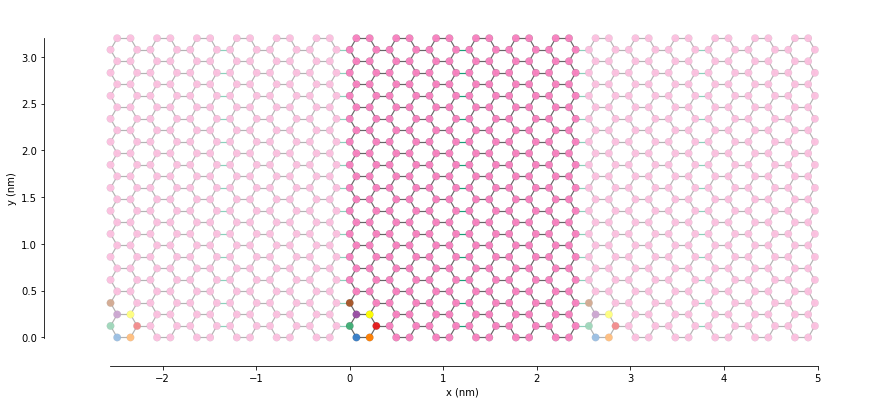

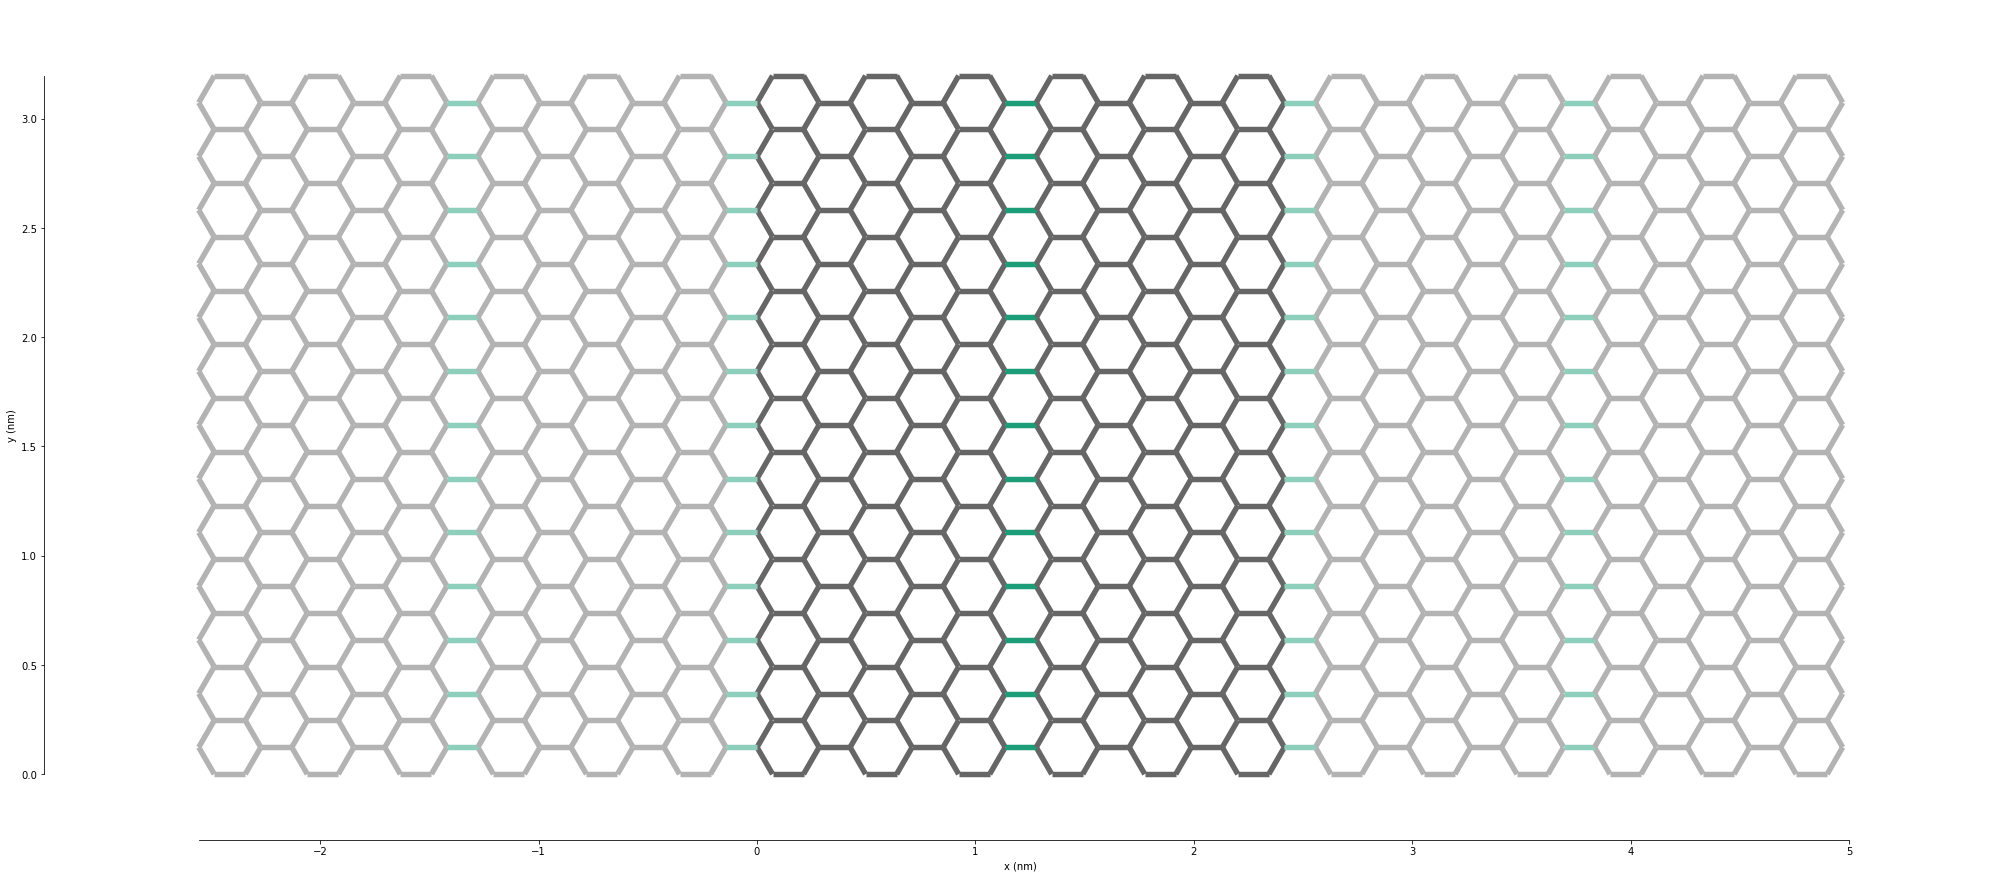

In [7]:
N1, N2, d = 27, 27, 0
#for i in range(3, N1 +1):
    #for j in range(3, N2 +1):
        #N1, N2 = i, j

lat_97ANGR = Lat_two_seg_AGNR(N1, N2, start_y_seg2 = d,
                                  t1=-2.8, t2=-2.8, t_interface = -2.,
                                  onsite1=0, onsite2=0)#onsite1=Onsite1[i], onsite2=-Onsite1[i])
plt.figure(figsize=(15,10))
lat_97ANGR.plot()
model_97ANGR = pb.Model(lat_97ANGR,
                            #geom_97AGNR,
                       pb.translational_symmetry(a1 = True, a2= False))
plt.figure(figsize=(15,10))


model_97ANGR.plot(hopping={'width': 2, 'cmap': 'auto'})
plt.show()

plt.figure(figsize=(35,25))
model_97ANGR.plot(site={"radius": 0},hopping={'width': 5, 'cmap': 'auto'})
plt.show()

In [8]:

pb.save(lat_97ANGR, 'lattice_file')
load1 = pb.load('lattice_file')
plt.figure(figsize=(15,10))
load1.plot()

# N1 = 20, N2 = 10 ~ 20,


## ytrans = $0, 1, (d-1), d, d+1, \Delta-1, \Delta$

In [9]:
def plot_forloop(N1end = 20, N2end = 20, N2start = 3, allYtrans = False):
           # ribbon width N1, N2, N1 for left segment, N2 for right segment
    loop_counter = 0 -1                   # minus one is added to make loop_counter start from 0
    for j in range(N2start, N2end +1):       # d is y-translation in an unit of ribbon width index
        for i in range(j, N1end +1):        # when there is no y-translation, d is 0
            diff = i - j
            d = int(diff/2)
            if allYtrans == True:
                d_list = range(diff + 1)
            elif allYtrans == False:
                if i%2 == 1:
                    if diff == 0:
                        d_list = [0]
                    elif diff <= 3 and diff >= 1:
                        d_list = [0, 1]       #[d_temp for d_temp in range(0, d)]
                    elif diff >= 4:
                        d_list = [0, 1, d]
                elif i%2 == 0:
                    if j%2 == 0:
                        if diff <= 6:
                            d_list = [d_temp for d_temp in range(0, diff + 1)]
                        elif diff >= 7: # actually, diff is even number because i, j are even.
                            d_list = [0, 1, d-1, d, d+1, diff-1, diff]
                    elif j%2 == 1:
                        if diff <= 4: # actually, diff is odd number because i is even, j is odd.
                            d_list = [d_temp for d_temp in range(0, diff + 1)]
                        elif diff >= 5: 
                            d_list = [0, 1, d, d+1, diff-1, diff]

            
            for k in d_list:
                print('i', i, 'j', j, 'k', k)
                loop_counter += 1
                print('k', k)
                print('d_list', d_list)
                plt.figure(1, figsize=(15,10))
                plt.figure(2, figsize=(15,10))
                plt.figure(3, figsize=(15,10))


                N1, N2, d = i, j, k
                lat_ANGR = Lat_two_seg_AGNR(N1, N2, start_y_seg2 = d,
                                                  t1=-2.8, t2=-2.8, t_interface = -2.8,
                                                  onsite1=0, onsite2=0)#onsite1=Onsite1[i], onsite2=-Onsite1[i])
                model_ANGR = pb.Model(lat_ANGR,
                                      pb.translational_symmetry(a1 = True, a2= False))

                solver_sym = solver()
                solver_sym.define_solver(model_ANGR)

                plt.figure(3)
                #plt.subplot(121)
                solver_sym.plots_band(ylim = 1.5, ylimswitch = True, 
                      dos_broadening = 0.05, show_H = False,
                      band_title= '', dos_title = '', showDos = True,
                      bandEnergySave = True,  bandEnergy_name = 'plots_bandE_SC'+str(i)+str(j)+str(k),
                      dosSave        = False, dos_name = 'plots_dos_SC'+str(i)+str(j)+str(k))

                plt.figure(3), plt.subplot(121)
                objFig = np.absolute(pb.load('plots_bandE_SC'+str(i)+str(j)+str(k)))
                Emin = min([min(objFig[i]) for i in range(0, len(objFig))])
                idx = np.where(objFig==Emin)
                idx = idx[0][0]
                #print('idx', idx)
                plt.scatter(idx, Emin, marker = '^', s= 100, color='r')
                plt.text(39*np.pi, 0.15, 'Emin:'+str(Emin)[:5]+'$eV$',   fontsize = 15)         
                plt.text(39*np.pi, 0,    'Egap:'+str(2*Emin)[:5]+'$eV$', fontsize = 15)         

                plt.subplot(122)
                plt.text(4, -1.5, 'broadening:'+str(solver_sym.dos_broadening)[:5]+'$eV$'
                         , horizontalalignment='left', fontsize = 15)

                plt.figure(2)
                plt.subplot(111)

                solver_sym.plots_spldos1(sp_ldos_energy = Emin, sp_ldos_broadening = 0.05)
                plt.text(3, -0.5, 'energy scope:'+str(Emin)[:5]+'$eV$', fontsize = 15)


                pbLoadPlot = False
                if pbLoadPlot == True:
                    plt.figure(3)
                    plt.subplot(122)
                    plt.plot(objFig)
                    plt.ylim(-1.5,1.5)
                    plt.show()

                plt.figure(1)
                Z2invClass = Z2inv()
                Z2 = [Z2invClass.Get_Z2(N = i, num_seg = 1),
                      Z2invClass.Get_Z2(N = j, num_seg = 2, ytrans = k), None]
                edge_list = Z2invClass.edge_list
                if Z2[0] == Z2[1]:
                    Z2[2] = 'sym'
                else:
                    Z2[2] = 'nonsym'


                table_temp = pd.DataFrame({'N1': str(i),
                              'N1'
                              'N2': str(j)+str('/ ')+edge_list[1],
                              'ytrans': k,
                              'Z2_N1': str(Z2[0]),
                              'Z2_N2': str(Z2[1]),
                              'Z2_prop': Z2[2],
                              '#atoms': str(3*2*i) +str('/ ')+ str(3*2*j) +str('/ ')+ str(3*2*(i+j))+'(total)',
                              'Egap$[eV]$': str(2*Emin)[:5]},
                                index =[loop_counter])

                if loop_counter == 0:
                    final_df = table_temp
                    #final_df = pd.concat([final_df, table_temp])#table_temp
                if loop_counter != 0:#0 :
                    final_df = pd.concat([final_df, table_temp])

                display(table_temp)
                plt.show()
        display(final_df)
        final_df.to_csv("combi_seg_final_df.csv", mode='w')

i 3 j 3 k 0
k 0
d_list range(0, 1)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
0,18/ 18/ 36(total),2.319,3,3/ Czig,0,0,sym,0


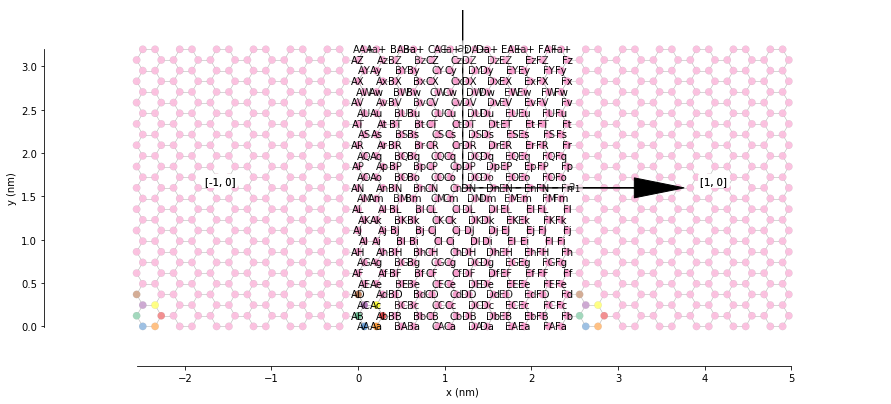

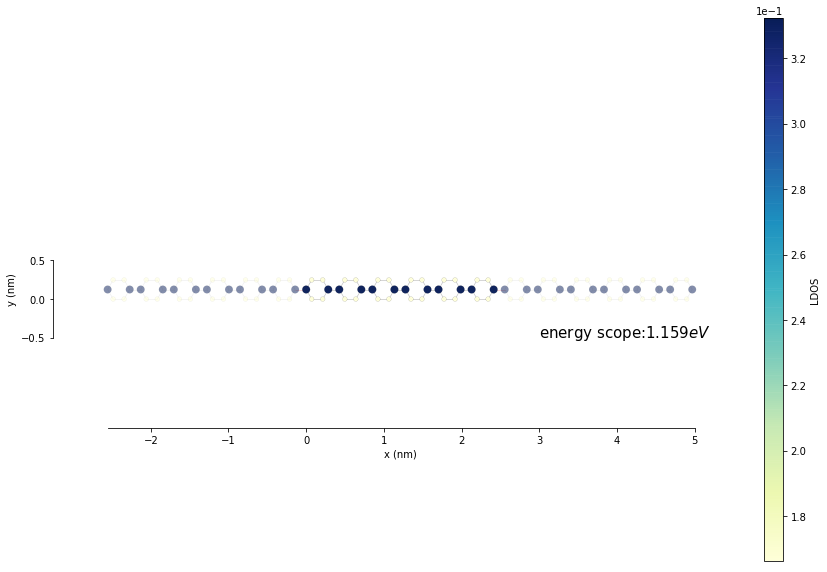

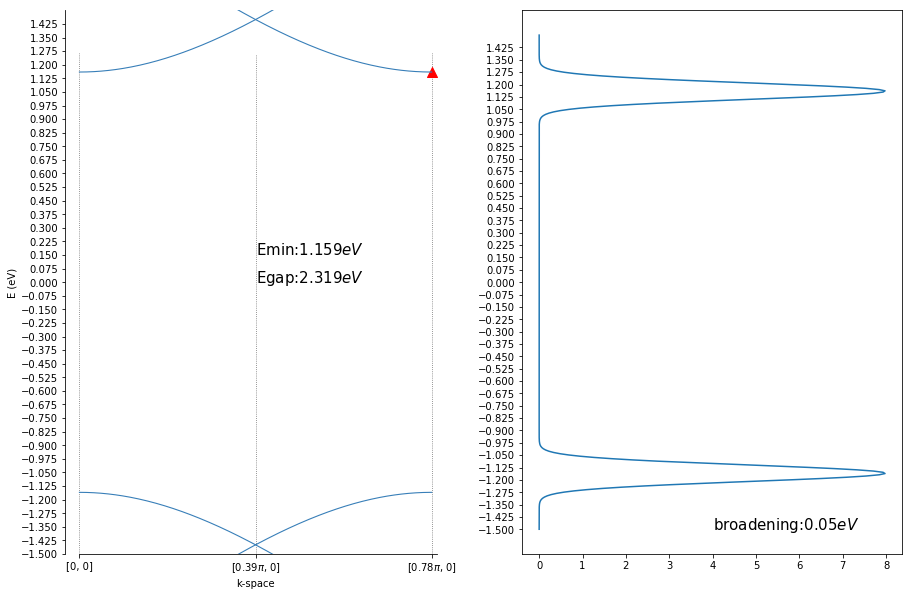

i 4 j 3 k 0
k 0
d_list range(0, 2)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
1,24/ 18/ 42(total),0.062,4,3/ Czig,1,0,nonsym,0


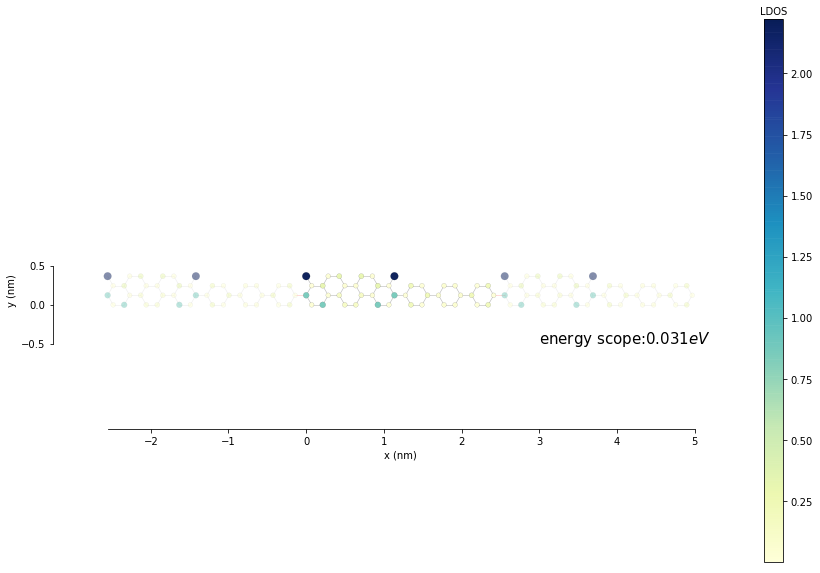

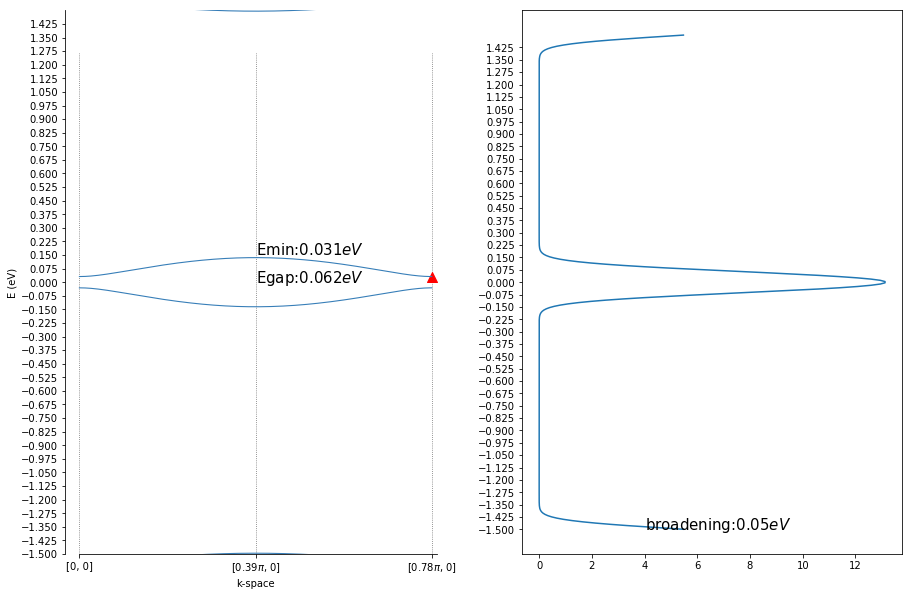

i 4 j 3 k 1
k 1
d_list range(0, 2)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
2,24/ 18/ 42(total),2.534,4,3/ Czig,1,0,nonsym,1


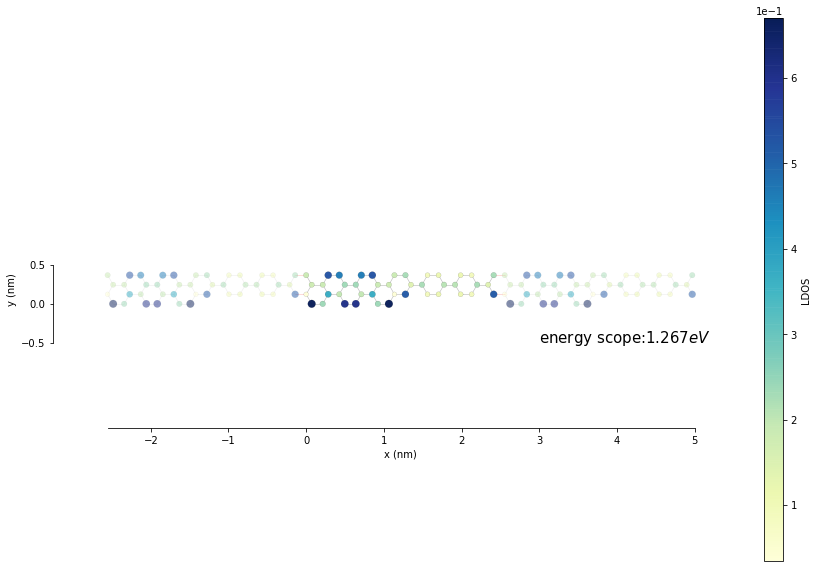

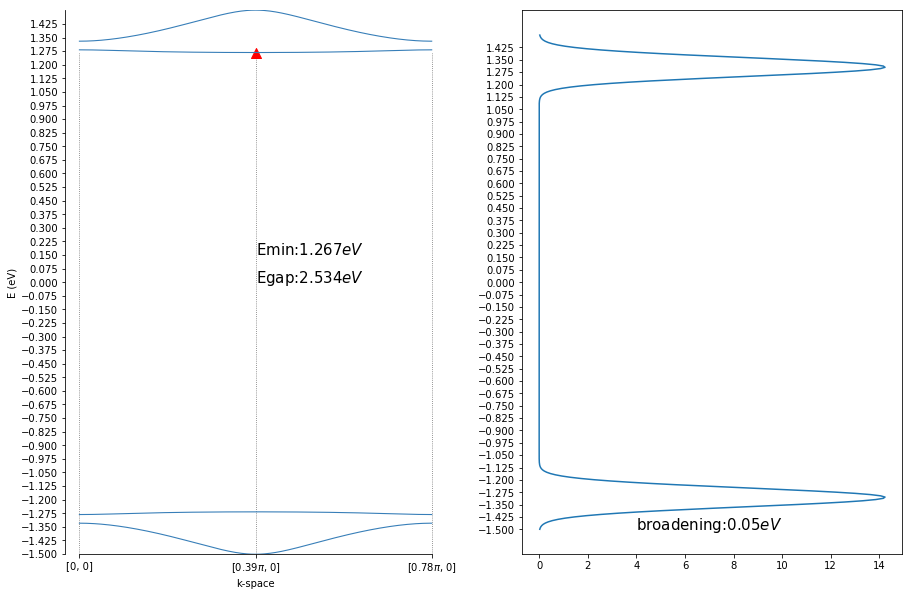

i 5 j 3 k 0
k 0
d_list range(0, 3)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
3,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,0


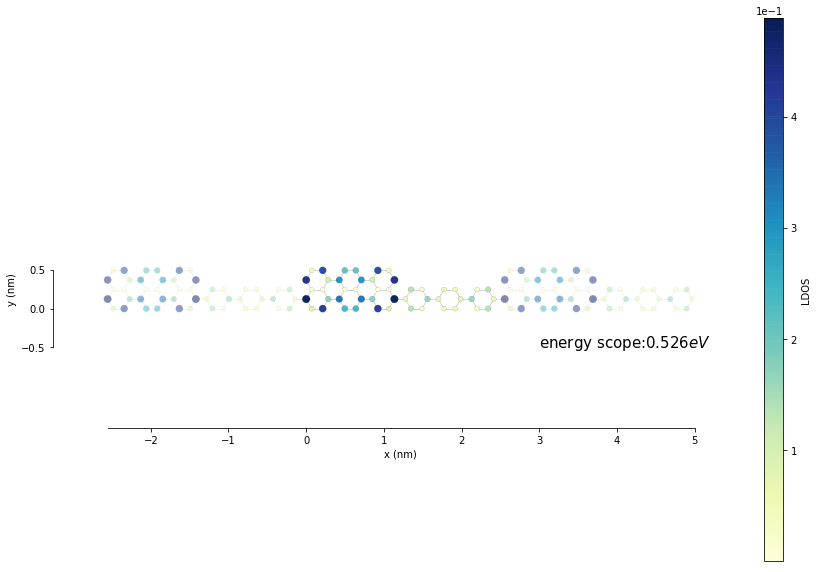

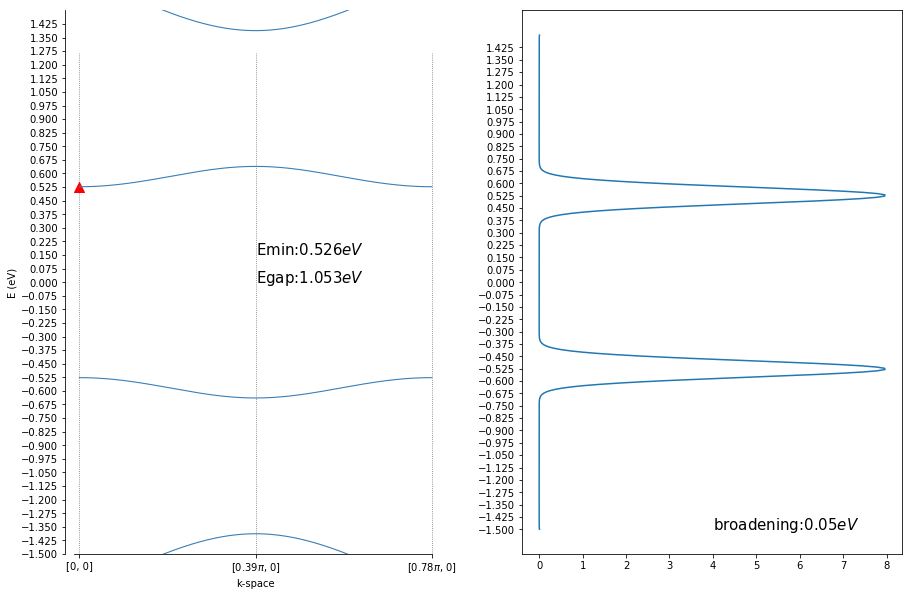

i 5 j 3 k 1
k 1
d_list range(0, 3)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
4,30/ 18/ 48(total),1.170,5,3/ Czig,1,0,nonsym,1


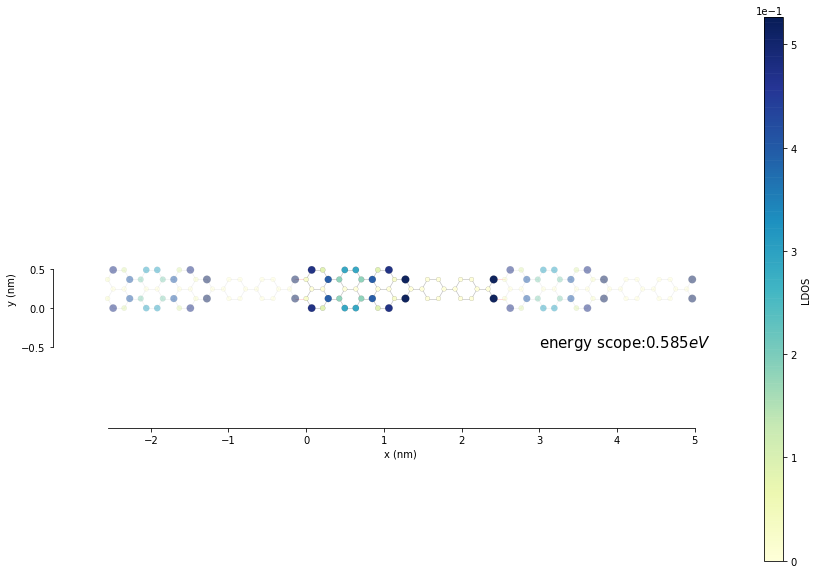

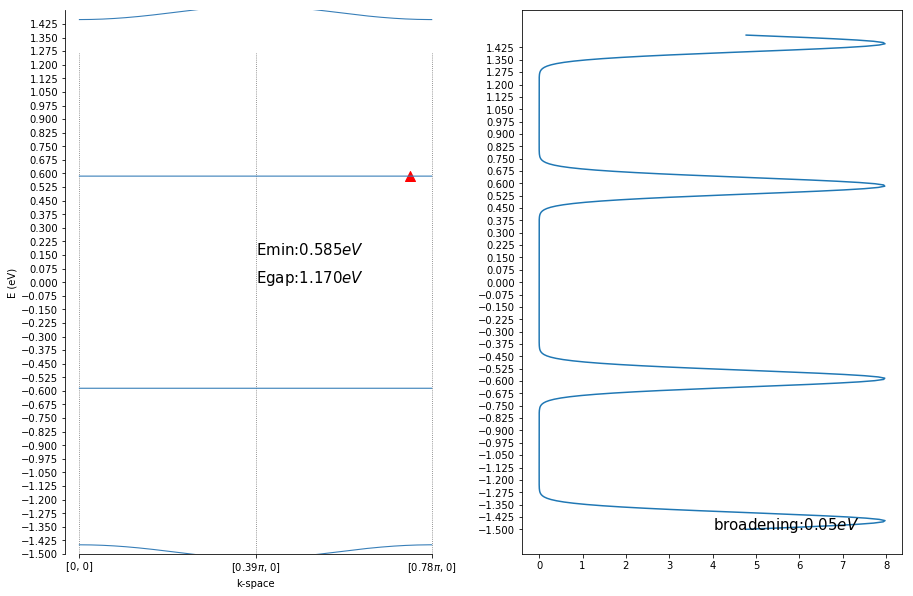

i 5 j 3 k 2
k 2
d_list range(0, 3)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
5,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,2


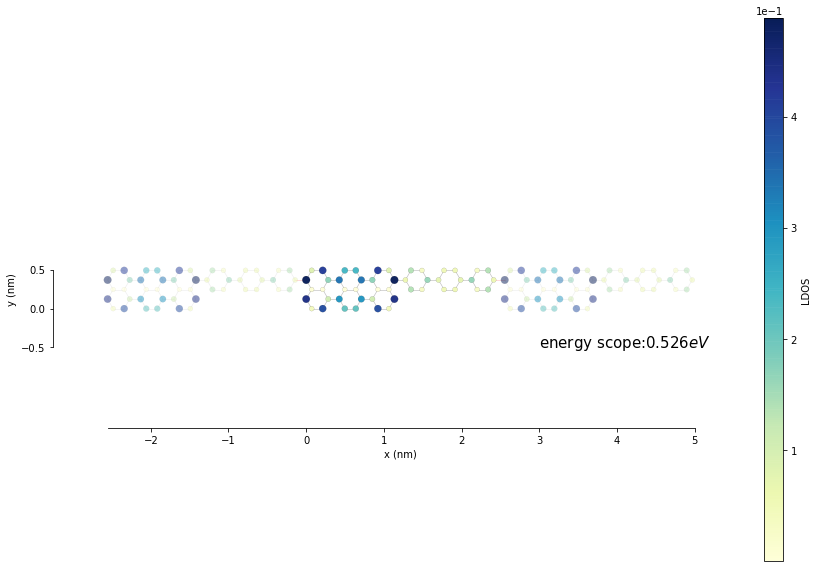

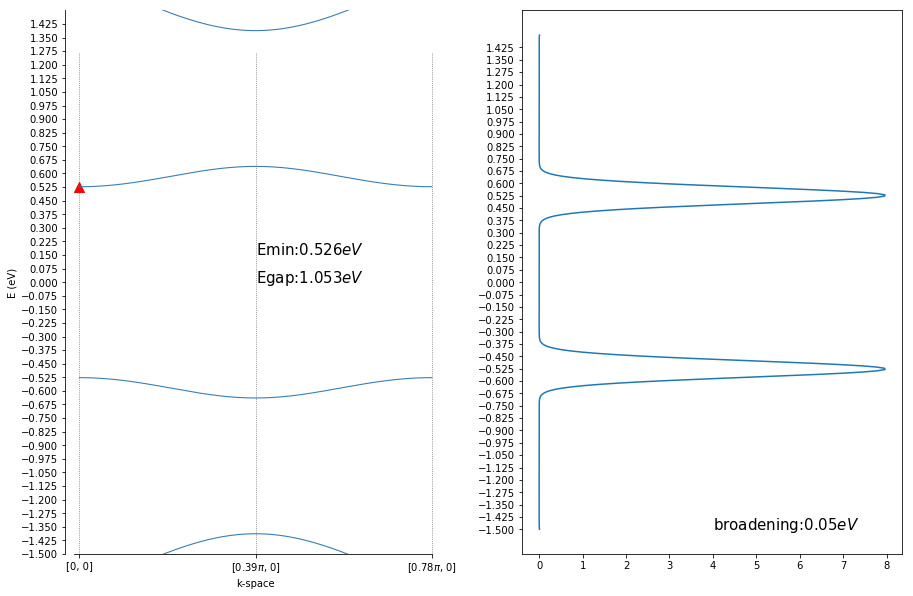

i 6 j 3 k 0
k 0
d_list range(0, 4)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
6,36/ 18/ 54(total),0.024,6,3/ Czig,1,0,nonsym,0


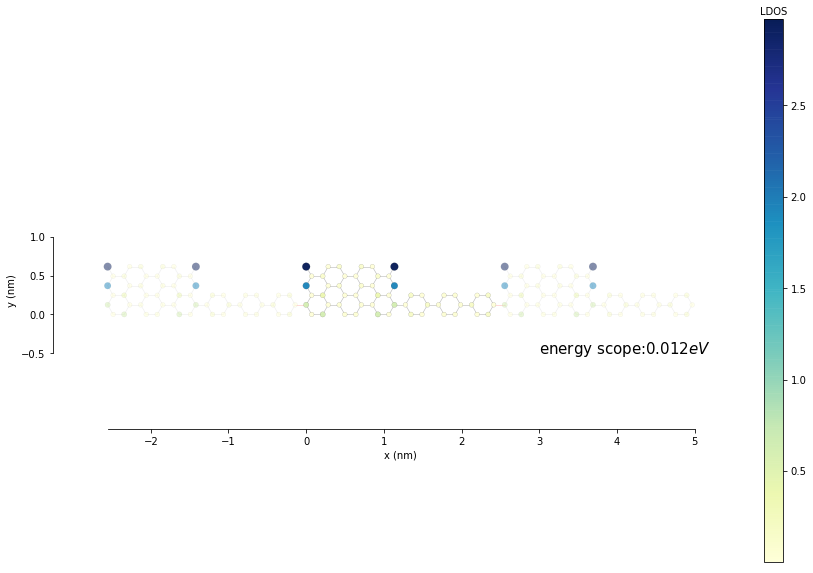

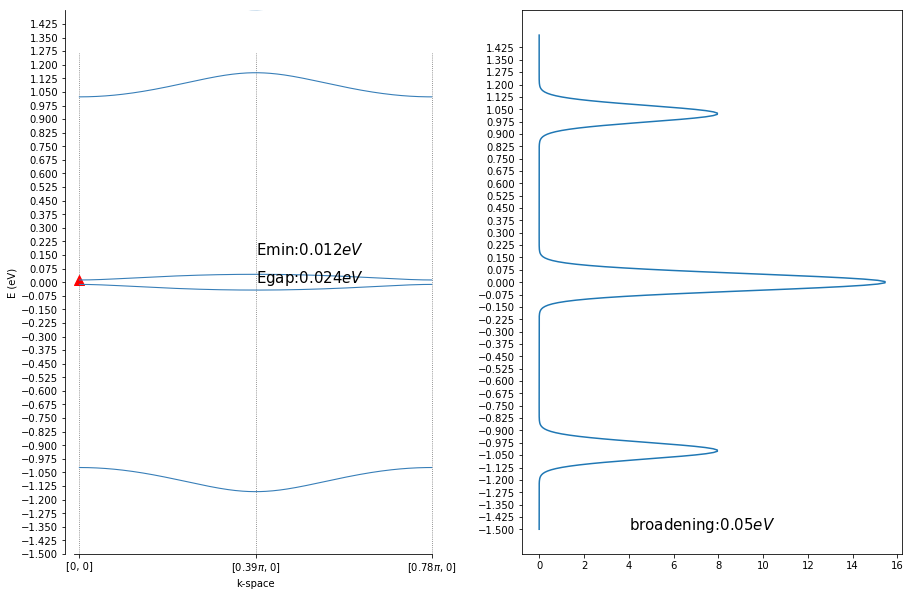

i 6 j 3 k 1
k 1
d_list range(0, 4)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
7,36/ 18/ 54(total),1.584,6,3/ Czig,1,0,nonsym,1


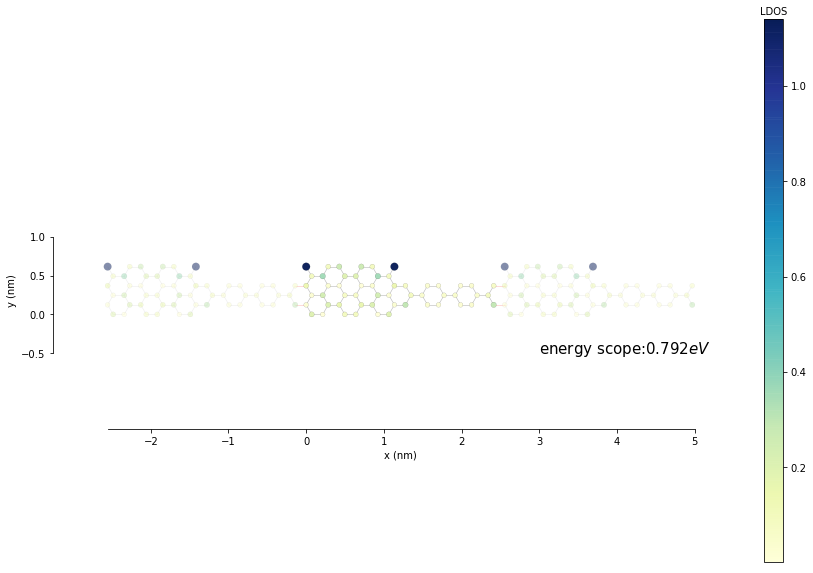

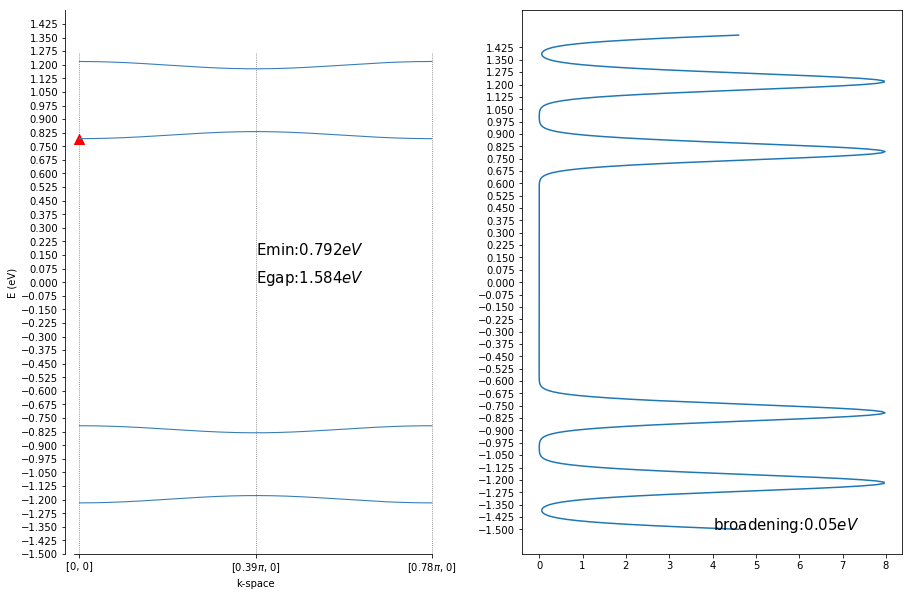

i 6 j 3 k 2
k 2
d_list range(0, 4)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
8,36/ 18/ 54(total),0.127,6,3/ Czig,1,0,nonsym,2


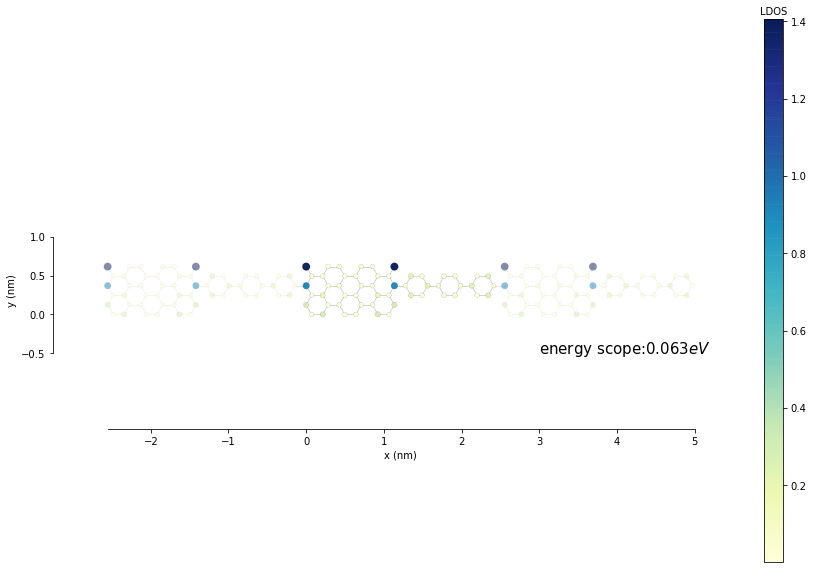

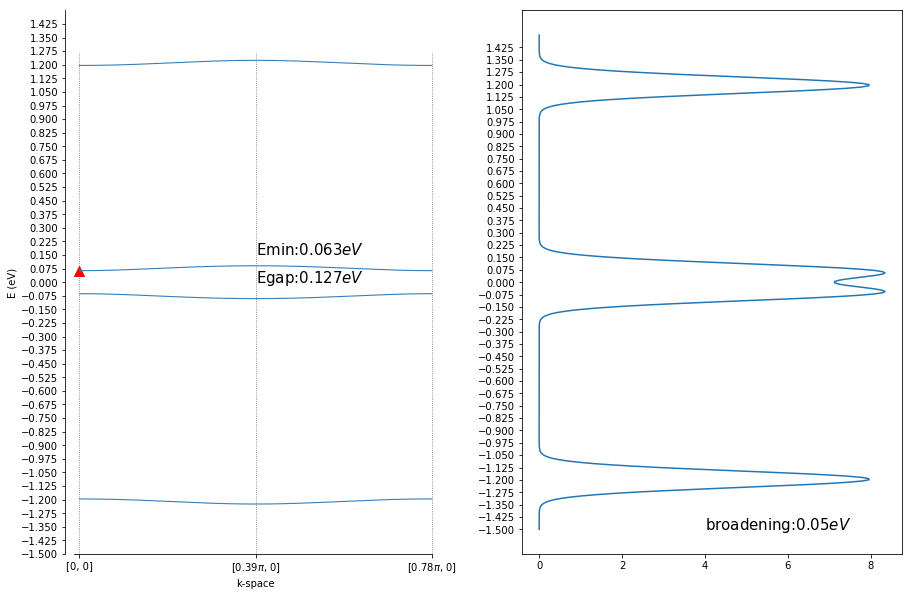

i 6 j 3 k 3
k 3
d_list range(0, 4)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
9,36/ 18/ 54(total),2.061,6,3/ Czig,1,0,nonsym,3


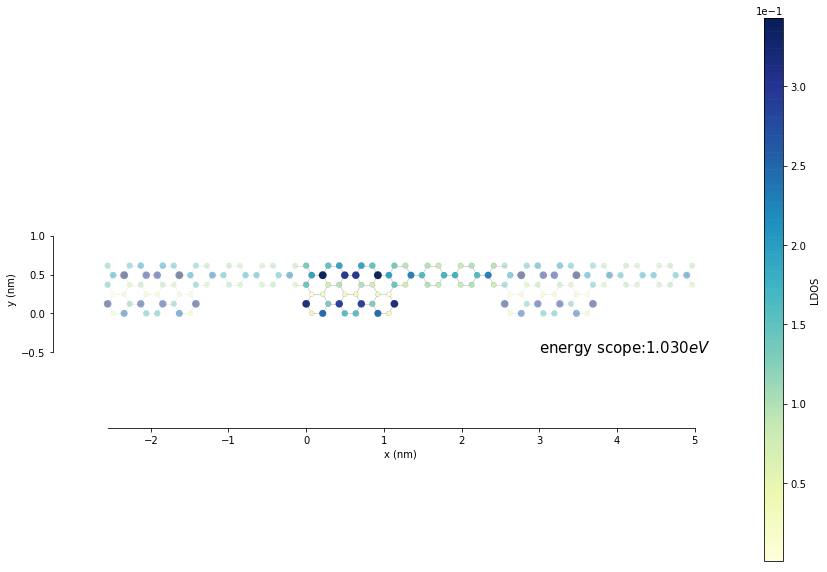

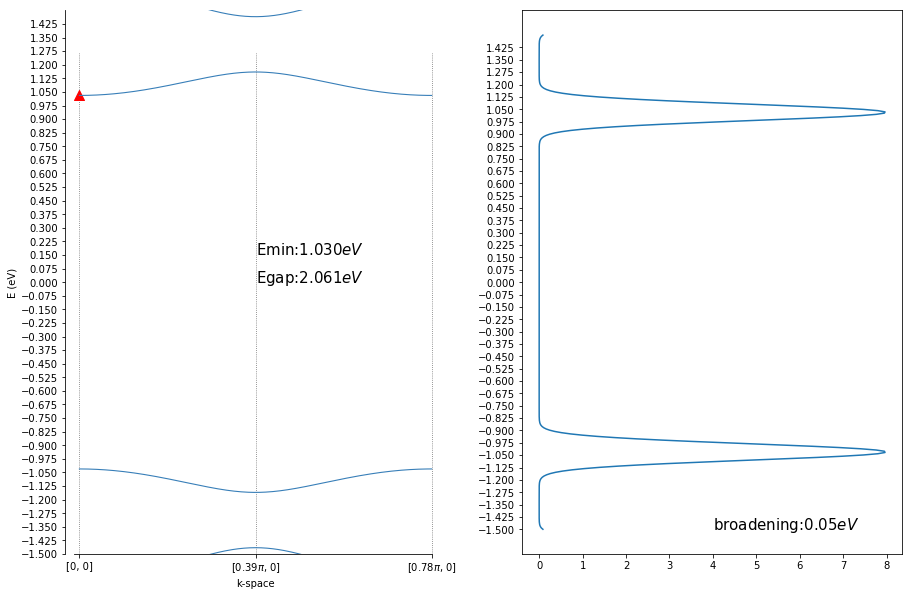

,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
0,18/ 18/ 36(total),2.319,3,3/ Czig,0,0,sym,0
1,24/ 18/ 42(total),0.062,4,3/ Czig,1,0,nonsym,0
2,24/ 18/ 42(total),2.534,4,3/ Czig,1,0,nonsym,1
3,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,0
4,30/ 18/ 48(total),1.170,5,3/ Czig,1,0,nonsym,1
5,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,2
6,36/ 18/ 54(total),0.024,6,3/ Czig,1,0,nonsym,0
7,36/ 18/ 54(total),1.584,6,3/ Czig,1,0,nonsym,1
8,36/ 18/ 54(total),0.127,6,3/ Czig,1,0,nonsym,2
9,36/ 18/ 54(total),2.061,6,3/ Czig,1,0,nonsym,3


i 4 j 4 k 0
k 0
d_list range(0, 1)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
10,24/ 24/ 48(total),2.139,4,4/ Czig,1,1,sym,0


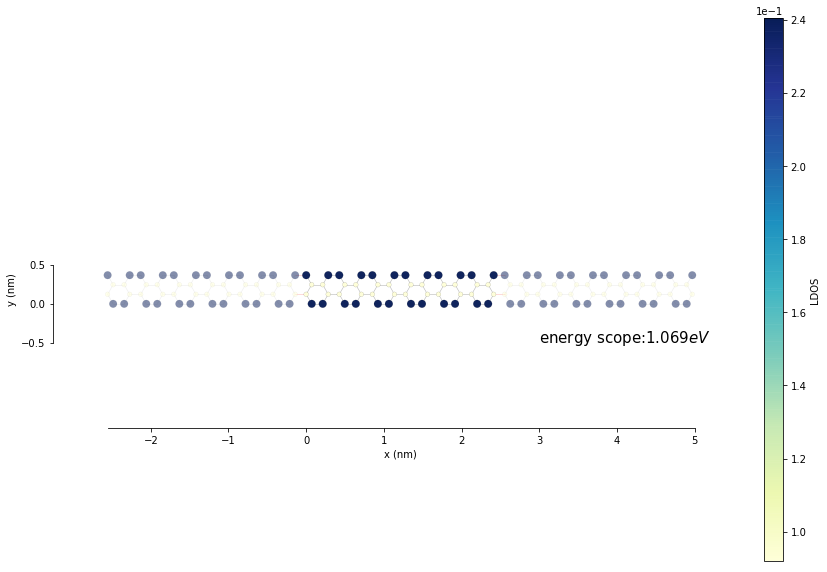

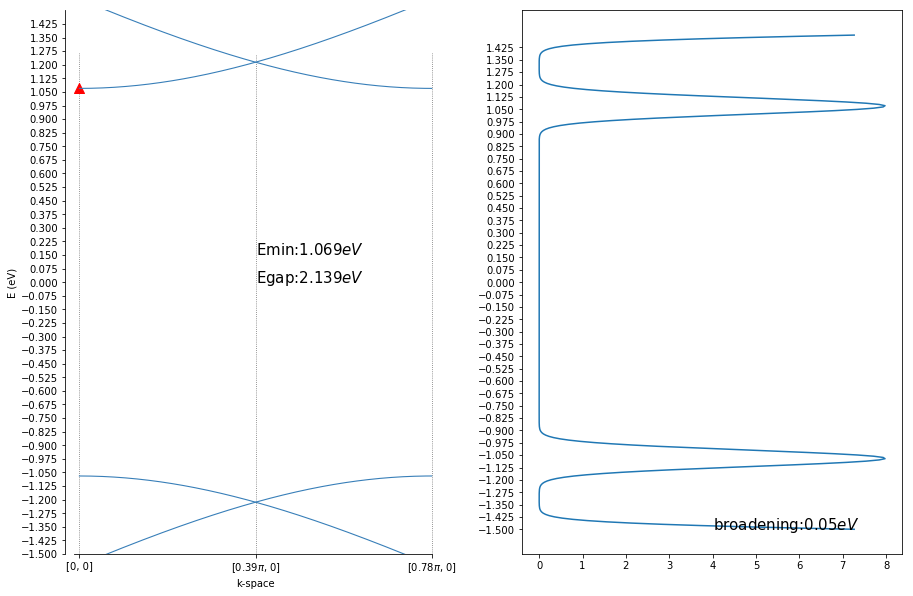

i 5 j 4 k 0
k 0
d_list range(0, 2)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
11,30/ 24/ 54(total),0.892,5,4/ Czig,1,1,sym,0


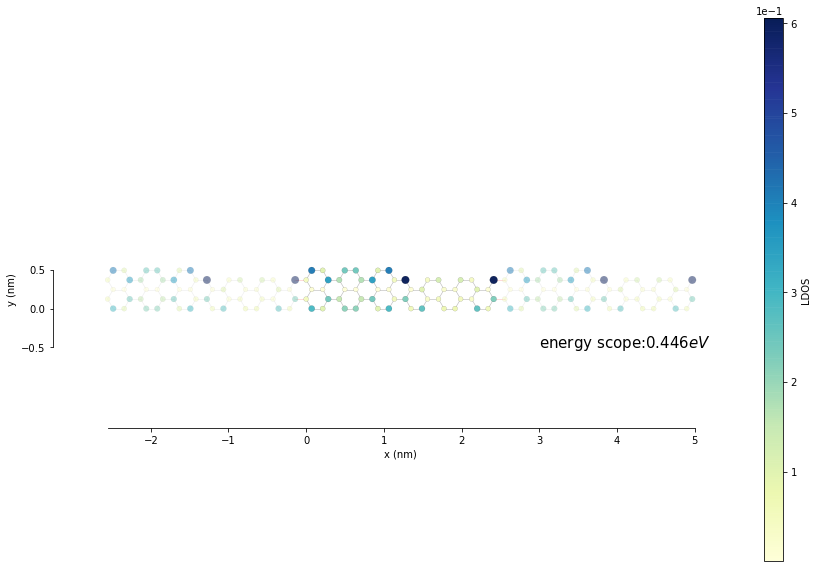

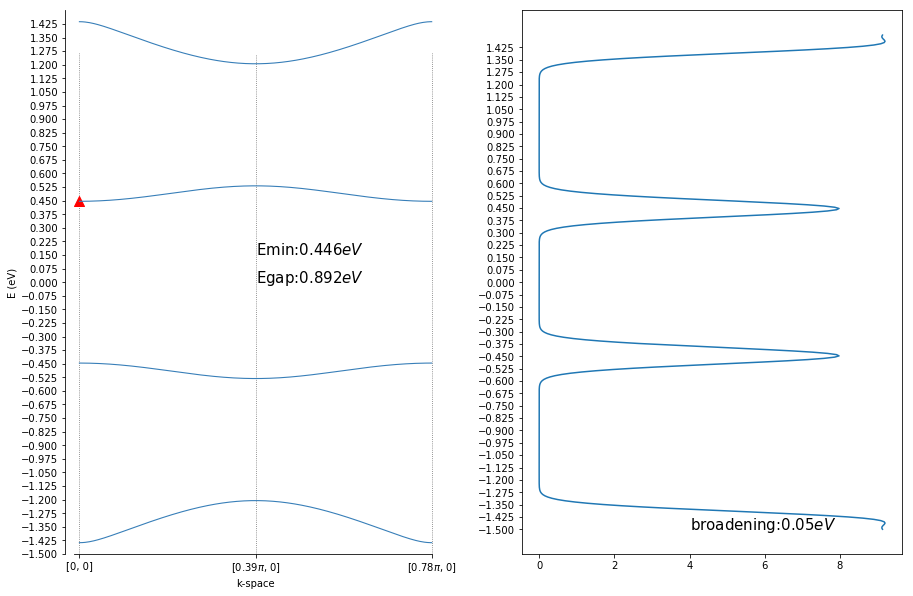

i 5 j 4 k 1
k 1
d_list range(0, 2)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
12,30/ 24/ 54(total),0.892,5,4/ Czig,1,0,nonsym,1


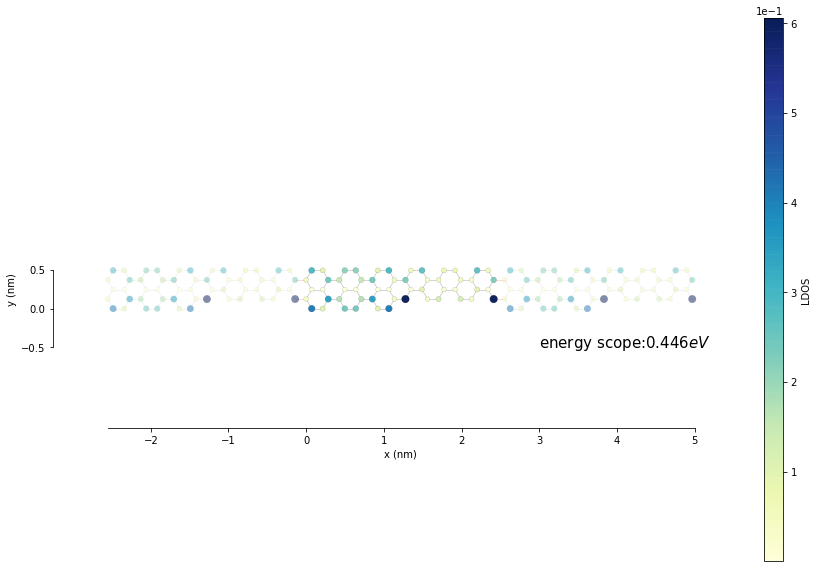

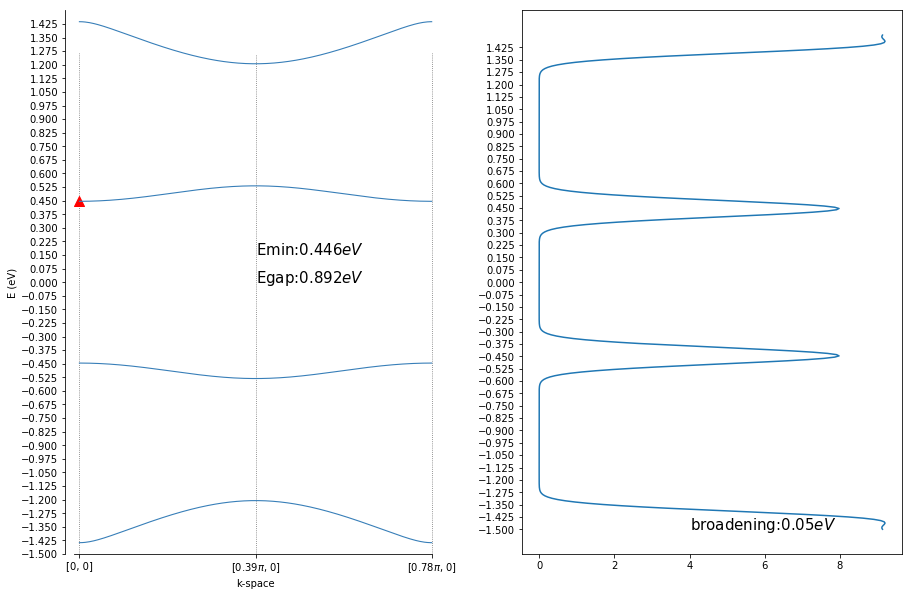

i 6 j 4 k 0
k 0
d_list range(0, 3)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
13,36/ 24/ 60(total),1.629,6,4/ Czig,1,1,sym,0


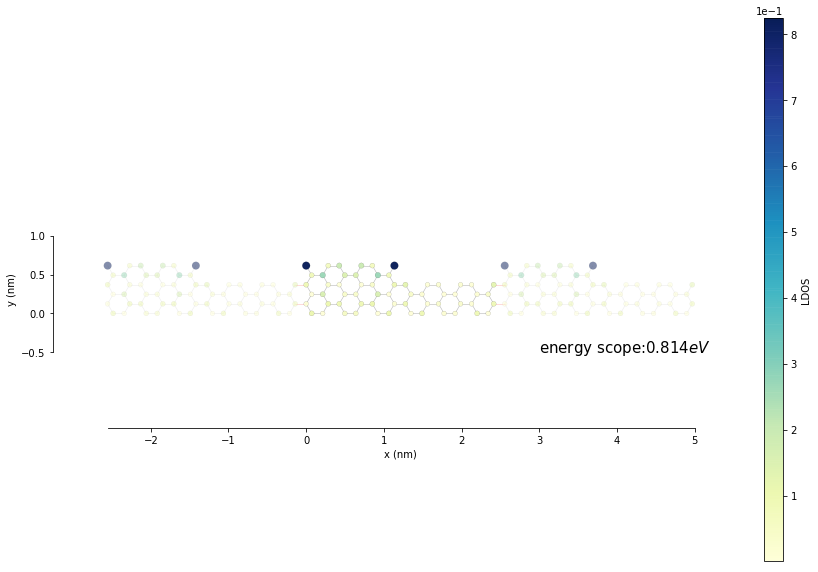

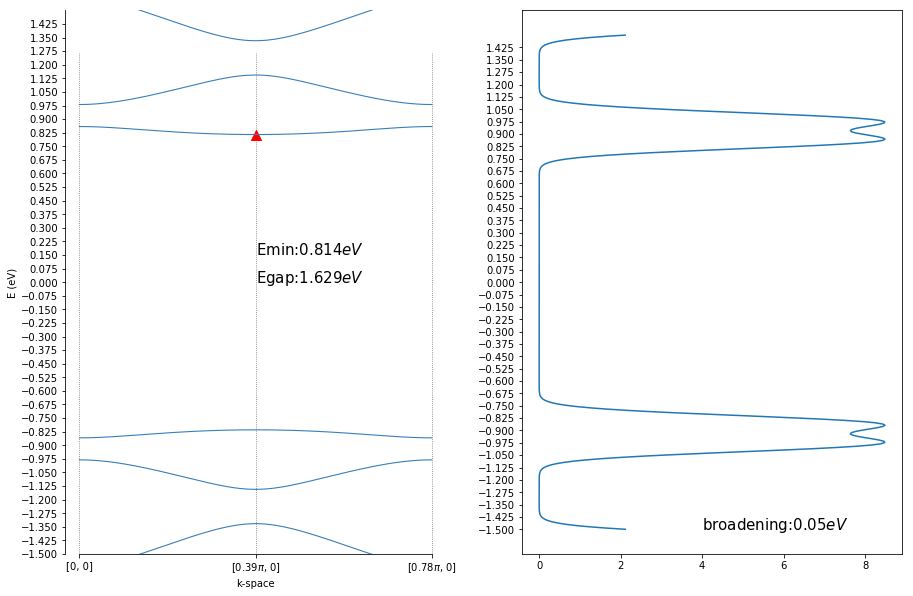

i 6 j 4 k 1
k 1
d_list range(0, 3)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
14,36/ 24/ 60(total),1.352,6,4/ Czig,1,1,sym,1


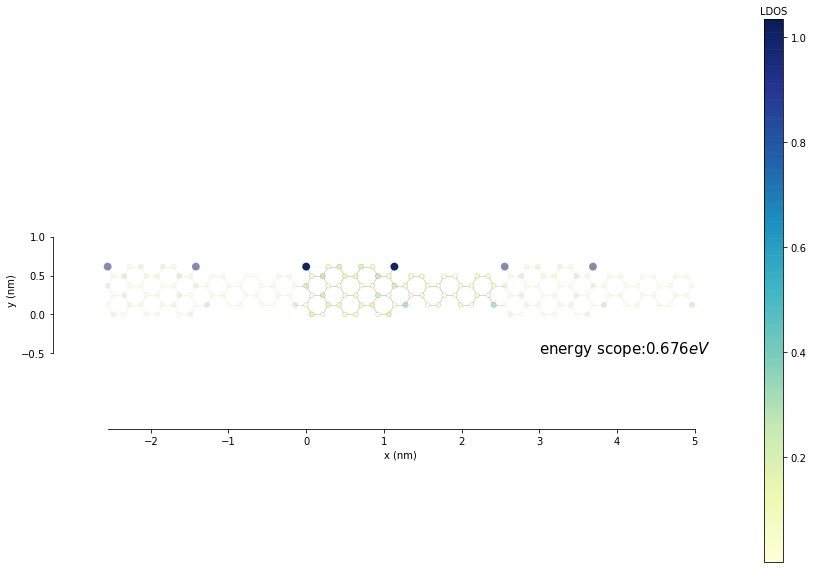

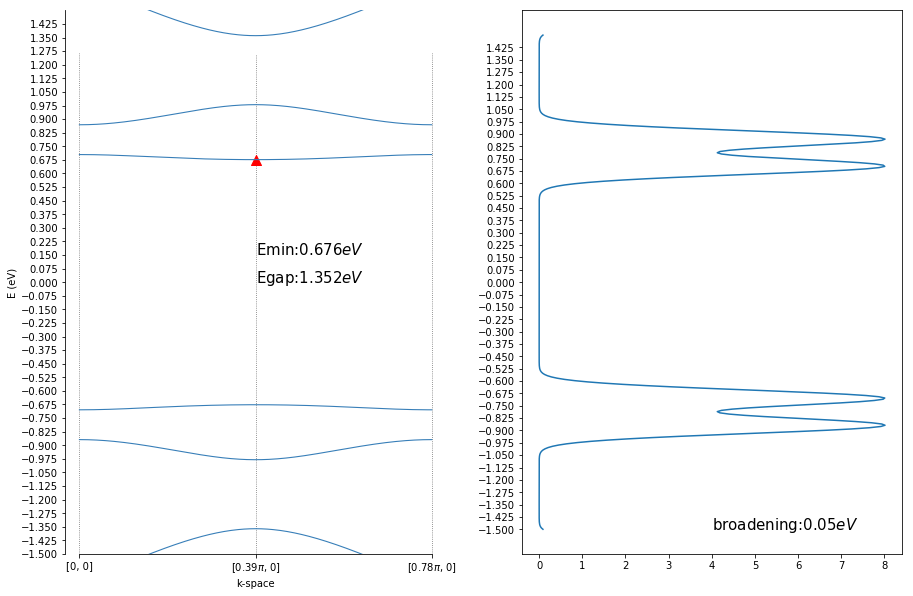

i 6 j 4 k 2
k 2
d_list range(0, 3)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
15,36/ 24/ 60(total),2.175,6,4/ Czig,1,1,sym,2


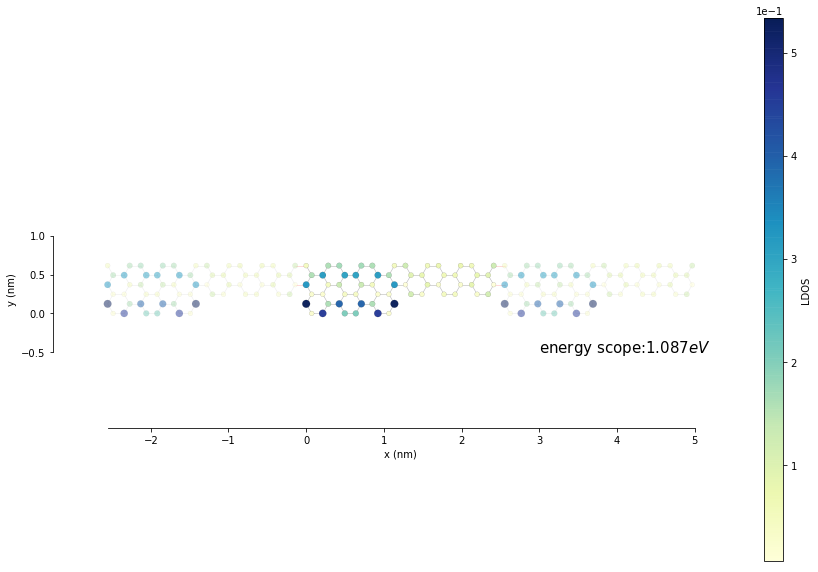

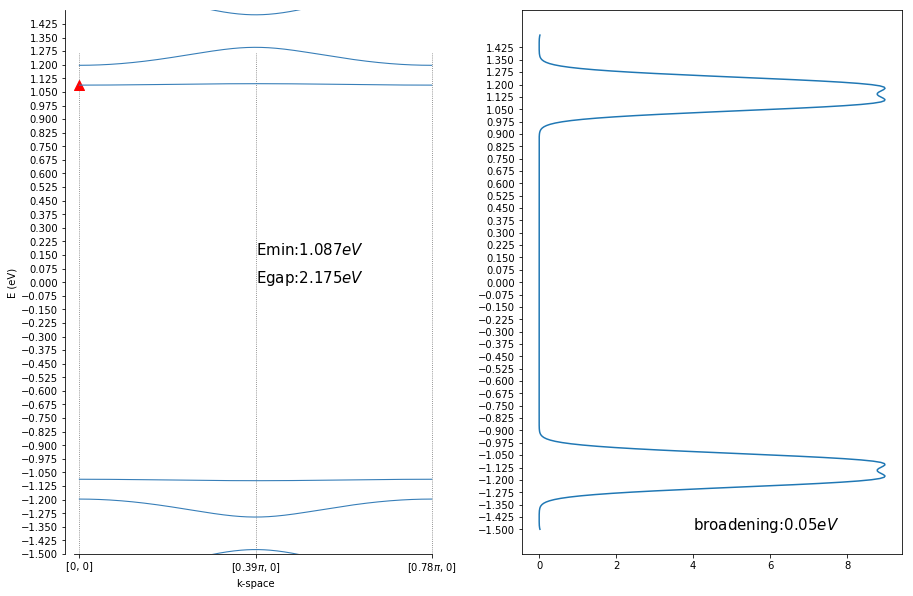

,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
0,18/ 18/ 36(total),2.319,3,3/ Czig,0,0,sym,0
1,24/ 18/ 42(total),0.062,4,3/ Czig,1,0,nonsym,0
2,24/ 18/ 42(total),2.534,4,3/ Czig,1,0,nonsym,1
3,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,0
4,30/ 18/ 48(total),1.170,5,3/ Czig,1,0,nonsym,1
5,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,2
6,36/ 18/ 54(total),0.024,6,3/ Czig,1,0,nonsym,0
7,36/ 18/ 54(total),1.584,6,3/ Czig,1,0,nonsym,1
8,36/ 18/ 54(total),0.127,6,3/ Czig,1,0,nonsym,2
9,36/ 18/ 54(total),2.061,6,3/ Czig,1,0,nonsym,3


i 5 j 5 k 0
k 0
d_list range(0, 1)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
16,30/ 30/ 60(total),2.735,5,5/ Czig,1,1,sym,0


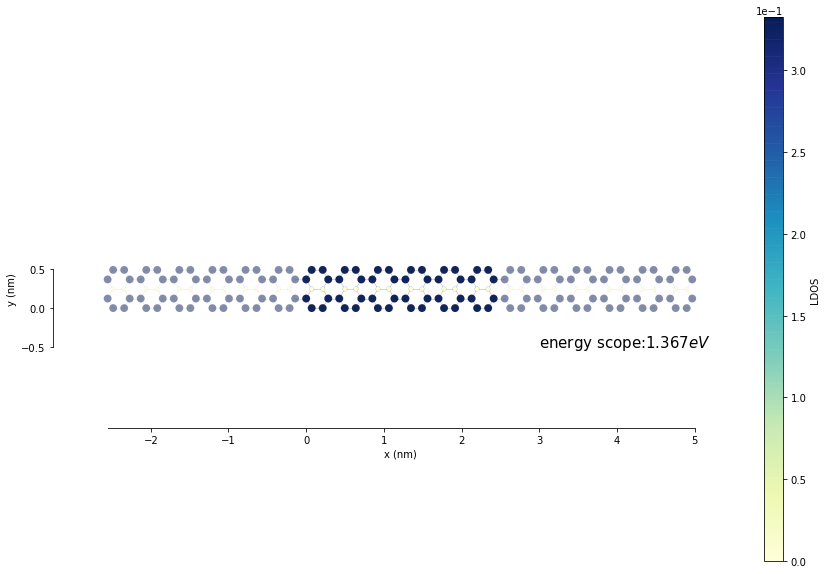

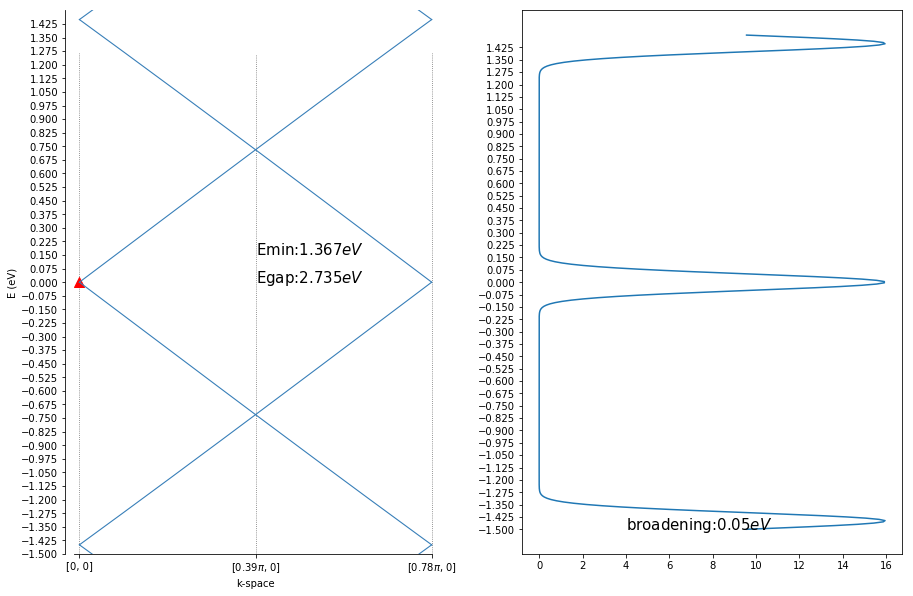

i 6 j 5 k 0
k 0
d_list range(0, 2)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
17,36/ 30/ 66(total),0.749,6,5/ Czig,1,1,sym,0


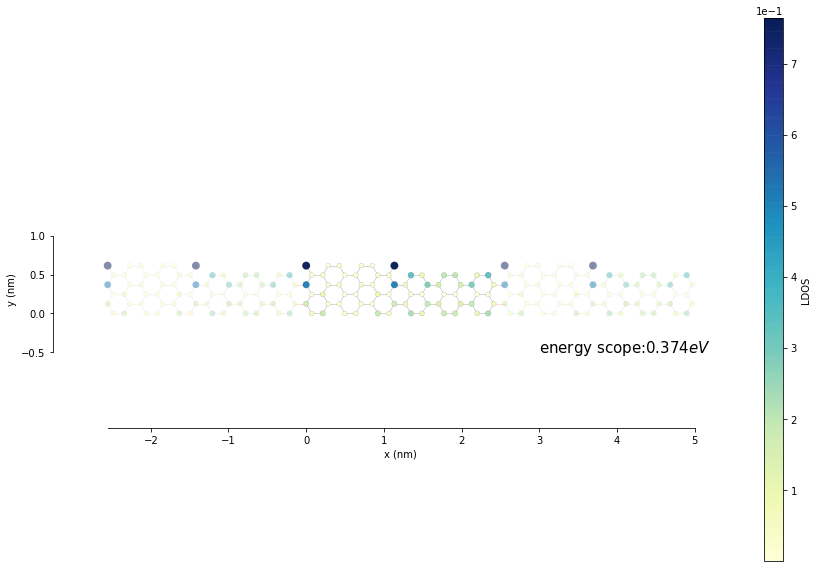

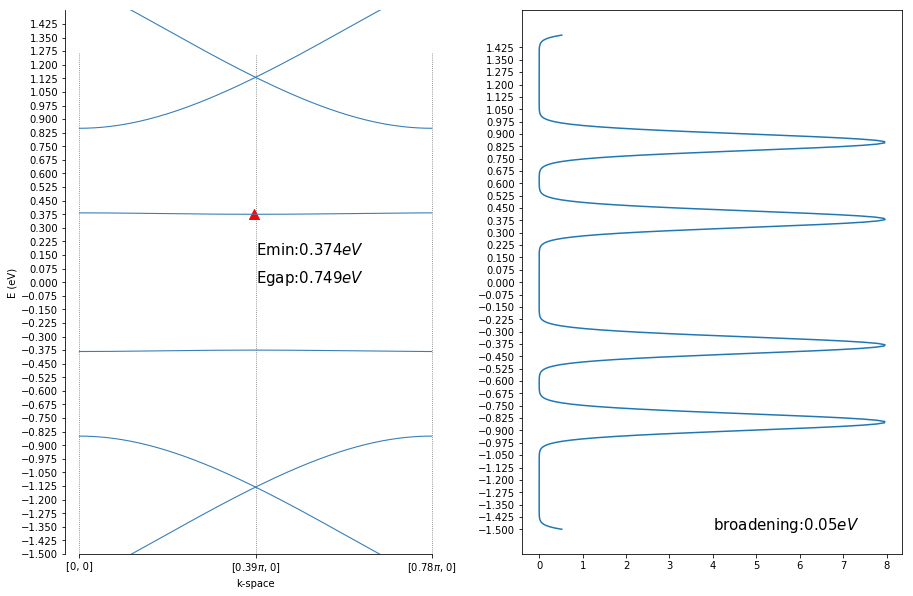

i 6 j 5 k 1
k 1
d_list range(0, 2)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
18,36/ 30/ 66(total),0.568,6,5/ Czig,1,1,sym,1


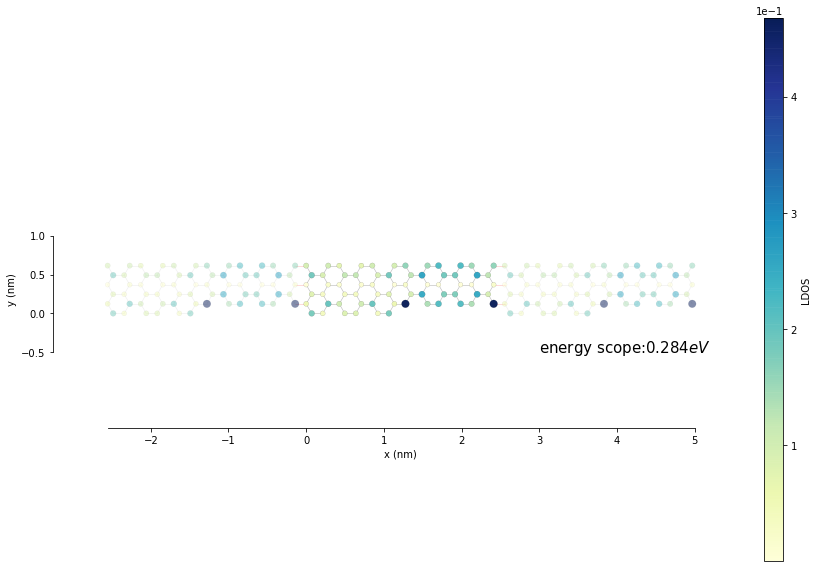

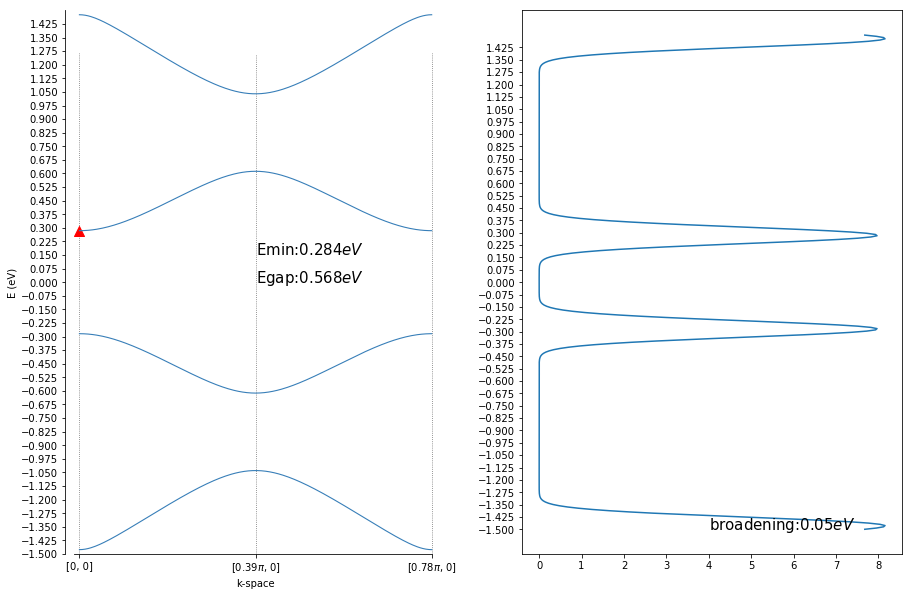

,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
0,18/ 18/ 36(total),2.319,3,3/ Czig,0,0,sym,0
1,24/ 18/ 42(total),0.062,4,3/ Czig,1,0,nonsym,0
2,24/ 18/ 42(total),2.534,4,3/ Czig,1,0,nonsym,1
3,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,0
4,30/ 18/ 48(total),1.170,5,3/ Czig,1,0,nonsym,1
5,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,2
6,36/ 18/ 54(total),0.024,6,3/ Czig,1,0,nonsym,0
7,36/ 18/ 54(total),1.584,6,3/ Czig,1,0,nonsym,1
8,36/ 18/ 54(total),0.127,6,3/ Czig,1,0,nonsym,2
9,36/ 18/ 54(total),2.061,6,3/ Czig,1,0,nonsym,3


i 6 j 6 k 0
k 0
d_list range(0, 1)


,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
19,36/ 36/ 72(total),1.383,6,6/ Czig,1,1,sym,0


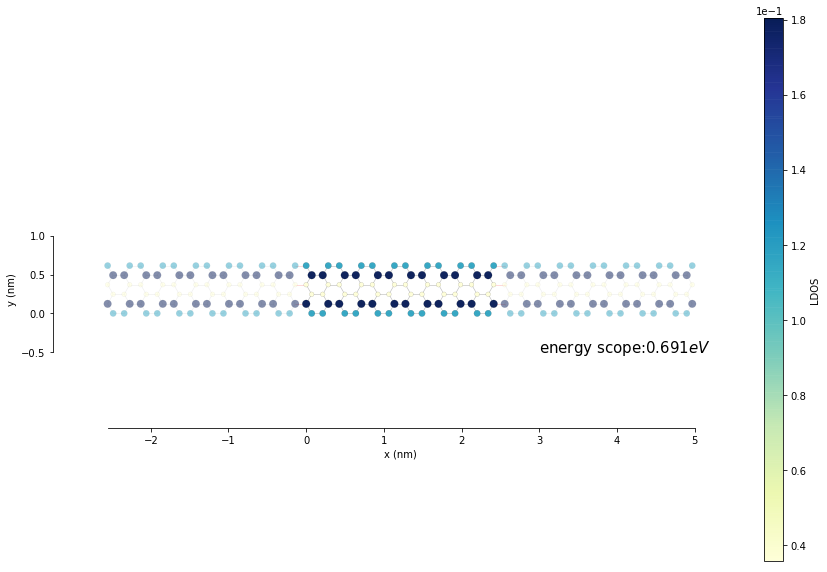

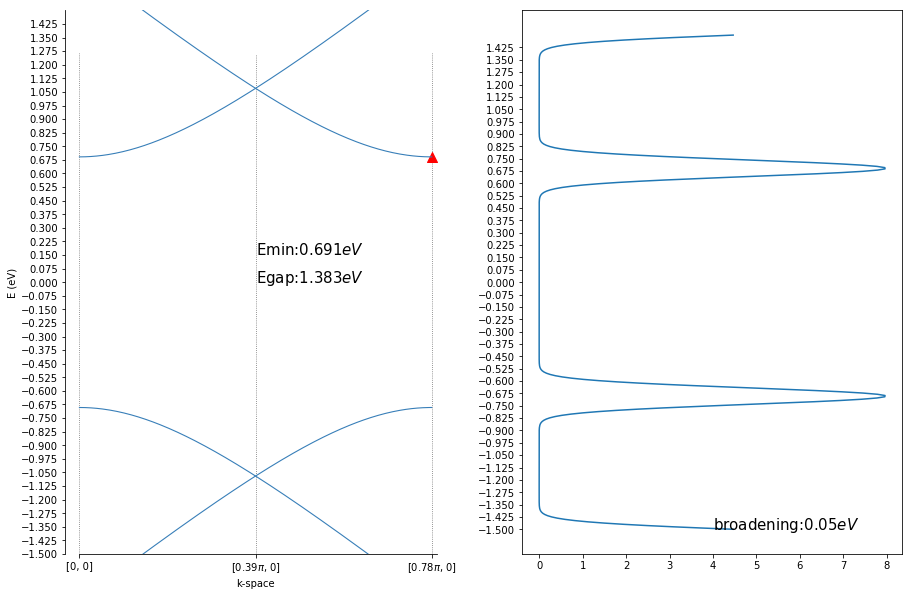

,#atoms,Egap$[eV]$,N1,N1N2,Z2_N1,Z2_N2,Z2_prop,ytrans
0,18/ 18/ 36(total),2.319,3,3/ Czig,0,0,sym,0
1,24/ 18/ 42(total),0.062,4,3/ Czig,1,0,nonsym,0
2,24/ 18/ 42(total),2.534,4,3/ Czig,1,0,nonsym,1
3,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,0
4,30/ 18/ 48(total),1.170,5,3/ Czig,1,0,nonsym,1
5,30/ 18/ 48(total),1.053,5,3/ Czig,1,0,nonsym,2
6,36/ 18/ 54(total),0.024,6,3/ Czig,1,0,nonsym,0
7,36/ 18/ 54(total),1.584,6,3/ Czig,1,0,nonsym,1
8,36/ 18/ 54(total),0.127,6,3/ Czig,1,0,nonsym,2
9,36/ 18/ 54(total),2.061,6,3/ Czig,1,0,nonsym,3


In [10]:
plot_forloop(N1end = 6, N2end = 6, N2start = 3, allYtrans = True)


In [11]:
plot_forloop(N1end = 20, N2end = 20, N1start = 3, N2start = 3)


TypeError: plot_forloop() got an unexpected keyword argument 'N1start'

In [ ]:
N1, N2, d = 10, 20, 0             #<- ribbon width N1, N2, N1 for left segment, N2 for right segment
N2start = 6
for j in range(N2start, N2 +1):       # d is y-translation in an unit of ribbon width index
    for i in range(20, N1 +1):   # when there is no y-translation, d is 0
        diff = i - j
        d = int(diff/2)
        if i%2 == 1:
            if diff <= 3:
                d_list = [0, 1]#[d_temp for d_temp in range(0, d)]
            elif diff >= 4:
                d_list = [0, 1, d]
        elif i%2 == 0:
            if j%2 == 0:
                if diff <= 6:
                    d_list = [d_temp for d_temp in range(0, diff + 1)]
                elif diff >= 7: # actually, diff is even number because i, j are even.
                    d_list = [0, 1, d-1, d, d+1, diff-1, diff]
            elif j%2 == 1:
                if diff <= 4: # actually, diff is odd number because i is even, j is odd.
                    d_list = [d_temp for d_temp in range(0, diff + 1)]
                elif diff >= 5: 
                    d_list = [0, 1, d, d+1, diff-1, diff]
                    
                    
        for k in d_list:
            print('k', k)
            print('d_list', d_list)
            plt.figure(1, figsize=(15,10))
            plt.figure(2, figsize=(15,10))
            plt.figure(3, figsize=(15,10))
            
            
            N2, N1, d = j, i, k
            lat_ANGR = Lat_two_seg_AGNR(N1, N2, start_y_seg2 = d,
                                              t1=-2.8, t2=-2.8, t_interface = -2.8,
                                              onsite1=0, onsite2=0)#onsite1=Onsite1[i], onsite2=-Onsite1[i])
            model_ANGR = pb.Model(lat_ANGR,
                                  pb.translational_symmetry(a1 = True, a2= False))

            solver_sym = solver()
            solver_sym.define_solver(model_ANGR)
            
            plt.figure(3)
            #plt.subplot(121)
            solver_sym.plots_band(ylim = 1.5, ylimswitch = True, 
                  dos_broadening = 0.05, show_H = False,
                  band_title= '', dos_title = '', showDos = True,
                  bandEnergySave = True,  bandEnergy_name = 'plots_bandE_SC'+str(i)+str(j)+str(k),
                  dosSave        = False, dos_name = 'plots_dos_SC'+str(i)+str(j)+str(k))
            
            plt.figure(3), plt.subplot(121)
            objFig = np.absolute(pb.load('plots_bandE_SC'+str(i)+str(j)+str(k)))
            Emin = min([min(objFig[i]) for i in range(0, len(objFig))])
            idx = np.where(objFig==Emin)
            idx = idx[0][0]
            #print('idx', idx)
            plt.scatter(idx, Emin, marker = '^', s= 100, color='r')
            plt.text(39*np.pi, 0.15, 'Emin:'+str(Emin)[:5]+'$eV$',   fontsize = 15)         
            plt.text(39*np.pi, 0,    'Egap:'+str(2*Emin)[:5]+'$eV$', fontsize = 15)         
            
            plt.subplot(122)
            plt.text(4, -1.5, 'broadening:'+str(solver_sym.dos_broadening)[:5]+'$eV$'
                     , horizontalalignment='left', fontsize = 15)
            
            plt.figure(2)
            plt.subplot(111)
            
            solver_sym.plots_spldos1(sp_ldos_energy = Emin, sp_ldos_broadening = 0.05)
            plt.text(3, -0.5, 'energy scope:'+str(Emin)[:5]+'$eV$', fontsize = 15)
            
            
            pbLoadPlot = False
            if pbLoadPlot == True:
                plt.figure(3)
                plt.subplot(122)
                plt.plot(objFig)
                plt.ylim(-1.5,1.5)
                plt.show()
            
            plt.figure(1)
            Z2invClass = Z2inv()
            Z2 = [Z2invClass.Get_Z2(N = i, num_seg = 1),
                  Z2invClass.Get_Z2(N = j, num_seg = 2, ytrans = k), None]
            if Z2[0] == Z2[1]:
                Z2[2] = 'sym'
            else:
                Z2[2] = 'nonsym'
                
            table_print = {'item': ['N1', 'N2', 'ytrans'],
                           'width': [i, j, k],
                           'Z2': Z2,
                           '#atoms': [3*2*i, 3*2*j, str(3*2*(i+j))+'(total)'],
                           'Egap$[eV]$': [str(2*Emin)[:5], None, None]}
            display(pd.DataFrame(table_print))

            plt.show()